In [1]:
from typing import List
from enum import Enum, auto
import numpy as np
import random

import matplotlib.pyplot as plt
import networkx as nx
import my_networkx as my_nx


In [2]:
WORLD_SIZE_x = 4
WORLD_SIZE_y = 4

In [3]:
class Percept():
    time_step: int
    bump: bool
    breeze: bool
    stench: bool
    scream: bool
    glitter: bool
    reward: int
    done: bool
        
    def __init__(self, time_step: int, bump: bool, breeze: bool, stench: bool, scream: bool, glitter: bool, reward: int, done: bool):
        # add code to set the instance variables of the percept
        self.time_step = time_step
        self.bump = bump
        self.breeze = breeze
        self.stench = stench
        self.scream = scream
        self.glitter = glitter
        self.reward = reward
        self.done = done

    def __str__(self):
        # add helper function to return the contents of a percept in a readable form
        return f"Percepts: Time Step={self.time_step}, Bump={self.bump}, Breeze={self.breeze}, Stench={self.stench}, Scream={self.scream}, Glitter={self.glitter}, Reward={self.reward}, Done={self.done}"

In [4]:
class Action(Enum):
    LEFT = 0
    RIGHT = 1
    FORWARD = 2
    GRAB = 3
    SHOOT = 4
    CLIMB = 5

In [5]:
class Orientation(Enum):
    E = 0
    S = 1
    W = 2
    N = 3

    def __str__(self) -> str:
        # code for function to return the letter code ("E", "S", etc.) of this instance of an orientation
        # You could create a __str__(self) for this instead of the symbol function if you prefer
        return self.name
    
    def turn_right(self) -> 'Orientation':
        # return a new orientation turned right
        # Note: the quotes around the type Orientation are because of a quirk in Python.  You can't refer
        # to Orientation without quotes until it is defined (and we are in the middle of defining it)
        if self == Orientation.E:
            return Orientation.S
        elif self == Orientation.S:
            return Orientation.W
        elif self == Orientation.W:
            return Orientation.N
        elif self == Orientation.N:
            return Orientation.E
        
    def turn_left(self) -> 'Orientation':
        # return a new orientation turned left
        if self == Orientation.E:
            return Orientation.N
        elif self == Orientation.N:
            return Orientation.W
        elif self == Orientation.W:
            return Orientation.S
        elif self == Orientation.S:
            return Orientation.E

In [6]:
class Location:
    x: int
    y: int
        
    def __init__(self, x: int, y: int):
        self.x = x
        self.y = y
        
    def __str__(self):
        return f'({self.x}, {self.y})'
    
    def __repr__(self) -> str:
        return f'({self.x}, {self.y})'
    
    def __eq__(self, other):
        if not isinstance(other, Location):
            return False
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def is_left_of(self, location: 'Location')->bool:
    # return True if self is just left of given location
        return self.x == location.x - 1 and self.y == location.y
   
    def is_right_of(self, location: 'Location')->bool:
    # return True if self is just right of given location  
        return self.x == location.x + 1 and self.y == location.y
    
    def is_above(self, location: 'Location')->bool:
    # return True if self is immediately above given location    
        return self.x == location.x and self.y == location.y+1
    
    def is_below(self, location: 'Location')->bool:
    # return True if self is immediately below given location   
        return self.x == location.x and self.y+1 == location.y
    
    def neighbours(self)->List['Location']:
    # return list of neighbour locations    
        neighbours = []
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            x, y = self.x + dx, self.y + dy
            if (1 <= x <= WORLD_SIZE_x) and (1 <= y <= WORLD_SIZE_y):
                neighbours.append(Location(x, y))
        return neighbours
    
    # return True if location given is self's location
    def is_location(self, location: 'Location')->bool:
        return self.x == location.x and self.y == location.y

    def at_left_edge(self) -> bool:
    # return True if at the left edge of the grid   
        return self.x == 1
    
    def at_right_edge(self) -> bool:
    # return True if at the right edge of the grid  
        return self.x == WORLD_SIZE_x
    
    def at_top_edge(self) -> bool:
    # return True if at the top edge of the grid    
        return self.y == WORLD_SIZE_y
   
    def at_bottom_edge(self) -> bool:
     # return True if at the bottom edge of the grid    
        return self.y == 1
    
    def forward(self, orientation) -> bool:
    # modify self.x and self.y to reflect a forward move and return True if bumped a wall  
        if orientation == Orientation.N:
            if self.at_top_edge():
                return True
            else:
                self.y = self.y+1
                return False
        elif orientation == Orientation.S:
            if self.at_bottom_edge():
                return True
            else:
                self.y = self.y-1
                return False
        elif orientation == Orientation.E:
            if self.at_right_edge():
                return True
            else:
                self.x = self.x+1
                return False
        elif orientation == Orientation.W:
            if self.at_left_edge():
                return True
            else:
                self.x = self.x-1
                return False

    def set_to(self, location: 'Location'):
    # set self.x and self.y to the given location  
        self.x = location.x
        self.y = location.y
    
    @staticmethod
    def from_linear(n: int) -> 'Location':
    # convert an index from 0 to 15 to a location
        x = (n % WORLD_SIZE_x) + 1
        y = (n // WORLD_SIZE_y) + 1
        return Location (x, y)
    
    
    def to_linear(self)->int:
    # convert self to an index from 0 to 15  
        return (self.y - 1) * WORLD_SIZE_y + (self.x - 1)  
    
    
    @staticmethod
    def random() -> 'Location':
        # return a random location   

        x = random.randint(1, WORLD_SIZE_x)
        y = random.randint(1, WORLD_SIZE_y)

        while x == 1 and y == 1:
            x = random.randint(1, WORLD_SIZE_x)
            y = random.randint(1, WORLD_SIZE_y) 

        return Location(x, y)

In [7]:
class Environment:
    wumpus_location: Location
    wumpus_alive: bool
    agent_location: Location
    agent_orientation: Orientation
    agent_has_arrow: bool
    agent_has_gold: bool
    game_over: bool
    gold_location: Location
    pit_locations: List[Location]
    time_step: int
        
    def __init__(self, width: int, height: int, allow_climb_without_gold: bool, pit_prob: float):
        # initialize the environment state variables (use make functions below)
        self.width = width
        self.height = height
        self.allow_climb_without_gold = allow_climb_without_gold
        self.pit_prob = pit_prob

        self.wumpus_location, self.wumpus_alive = self.make_wumpus()
        self.agent_location = Location(1,1)
        self.gold_location = self.make_gold()
        self.pit_locations = self.make_pits(self.pit_prob)
        self.agent_orientation = Orientation['E']
        self.agent_has_arrow = True
        self.agent_has_gold = False
        self.game_over = False
        self.time_step = 0
        
        
    def make_wumpus(self): 
        # choose a random location for the wumpus (not bottom left corner) and set it to alive
        while True:
            location = Location.random()
            if location != Location(1,1):  # Ensure it's not the bottom left corner
                self.wumpus_location = location
                self.wumpus_alive = True
                break
        return self.wumpus_location, self.wumpus_alive

    def make_gold(self):
        # choose a random location for the gold (not bottom left corner)
        while True:
            location = Location.random()
            if location != Location(1,1):  # Ensure it's not the bottom left corner
                self.gold_location = location
                break
        return self.gold_location
        
    def make_pits(self, pit_prob: float):
        # create pits with prob pit_prob for all locations except the bottom left corner
        self.pit_locations = []
        for x in range(1, self.width+1):
            for y in range(1, self.height+1):
                if (x, y) != (1, 1):  # Exclude bottom left corner
                    if random.random() < pit_prob:
                        self.pit_locations.append(Location(x, y))
        return self.pit_locations
        
    def is_pit_at(self, location: Location) -> bool:
        # return true if there is a pit at location
        return location in self.pit_locations
        
    def is_pit_adjacent_to_agent(self) -> bool:
        # return true if there is a pit above, below, left or right of agent's current location
        for pit in self.pit_locations:
            if pit in self.agent_location.neighbours():
                return True
        return False
                
    def is_wumpus_adjacent_to_agent(self) -> bool:
        # return true if there is a wumpus adjacent to the agent
        if self.wumpus_location in self.agent_location.neighbours():
                return True
        return False
        
    def is_agent_at_hazard(self)->bool:
        # return true if the agent is at the location of a pit or the wumpus
        return (self.agent_location == self.wumpus_location and self.wumpus_alive==True) or self.is_pit_at(self.agent_location)
        
    def is_wumpus_at(self, location: Location) -> bool:
        # return true if there is a wumpus at the given location
        return self.wumpus_location == location
        
    def is_agent_at(self, location: Location) -> bool:
        # return true if the agent is at the given location
        return self.agent_location == location
        
    def is_gold_at(self, location: Location) -> bool:
        # return true if the gold is at the given location
        return self.gold_location == location
        
    def is_glitter(self) -> bool:
        # return true if the agent is where the gold is
        return self.agent_location == self.gold_location
        
    def is_breeze(self) -> bool:
        # return true if one or pits are adjacent to the agent or the agent is in a room with a pit
        if self.is_pit_adjacent_to_agent():
            return True
        if self.is_pit_at(self.agent_location):
            return True
        return False
    
    def is_stench(self) -> bool:
        # return true if the wumpus is adjacent to the agent or the agent is in the room with the wumpus
        if self.is_wumpus_adjacent_to_agent():
            return True
        if self.is_wumpus_at(self.agent_location):
            return True
        return False

    def wumpus_in_line_of_fire(self) -> bool:
        # return true if the wumpus is a cell the arrow would pass through if fired
        if self.agent_orientation == Orientation['E']:
            if (self.agent_location.x < self.wumpus_location.x) and (self.agent_location.y == self.wumpus_location.y):
                return True
        if self.agent_orientation == Orientation['W']:
            if (self.agent_location.x > self.wumpus_location.x) and (self.agent_location.y == self.wumpus_location.y):
                return True
        if self.agent_orientation == Orientation['N']:
            if (self.agent_location.x == self.wumpus_location.x) and (self.agent_location.y < self.wumpus_location.y):
                return True
        if self.agent_orientation == Orientation['S']:
            if (self.agent_location.x == self.wumpus_location.x) and (self.agent_location.y > self.wumpus_location.y):
                return True
        else:
            return False


    def kill_attempt(self) -> bool:
        # return true if the wumpus is alive and in the line of fire
        # if so set the wumpus to dead
        if self.wumpus_in_line_of_fire() and self.wumpus_alive and self.agent_has_arrow:
            self.wumpus_alive = False
        self.agent_has_arrow = False
        return self.wumpus_alive
        
    def step(self, action: Action) -> Percept:
        # for each of the actions, make any agent state changes that result and return a percept including the reward
        # First, update agent state based on action
        if action == Action.LEFT:
            # Turn agent left
            self.agent_orientation = self.agent_orientation.turn_left()
            return Percept(time_step=self.time_step+1, bump=False, breeze=self.is_breeze(), stench=self.is_stench(), scream=False, glitter=self.is_glitter(), reward=-1, done=self.game_over)

        elif action == Action.RIGHT:
            # Turn agent right
            self.agent_orientation = self.agent_orientation.turn_right()
            return Percept(time_step=self.time_step+1, bump=False, breeze=self.is_breeze(), stench=self.is_stench(), scream=False, glitter=self.is_glitter(), reward=-1, done=self.game_over)
    
        elif action == Action.FORWARD:
            # Move agent forward
            bump = self.agent_location.forward(self.agent_orientation)
            reward = -1
            if self.is_agent_at_hazard():
                reward -= 1000
                self.game_over = True
            if self.agent_has_gold == True:
                self.gold_location = self.agent_location
            return Percept(time_step=self.time_step+1, bump=bump, breeze=self.is_breeze(), stench=self.is_stench(), scream=False, glitter=self.is_glitter(), reward=reward, done=self.game_over)

        elif action == Action.GRAB:
            # Grab gold if present
            if self.is_glitter():
                self.agent_has_gold = True
            return Percept(time_step=self.time_step+1, bump=False, breeze=self.is_breeze(), stench=self.is_stench(), scream=False, glitter=self.is_glitter(), reward=-1, done=self.game_over)

        elif action == Action.SHOOT:
            # Shoot arrow 
            wumpus_orig_alive = self.wumpus_alive
            agent_has_arrow_orig = self.agent_has_arrow
            self.kill_attempt()
            wumpus_curr_alive = self.wumpus_alive
            agent_has_arrow_curr = self.agent_has_arrow
            self.agent_has_arrow = False
            if wumpus_orig_alive==True and wumpus_curr_alive == False:
                scream = True 
            else:
                scream = False
                
            if agent_has_arrow_orig == True and agent_has_arrow_curr == False:
                reward = -10
            else:
                reward = -1
            return Percept(time_step=self.time_step+1, bump=False, breeze=self.is_breeze(), stench=self.is_stench(), scream=scream, glitter=self.is_glitter(), reward=reward, done=self.game_over)

        elif action == Action.CLIMB:
            # Climb out of cave 
            if self.agent_location == Location(1,1) and self.allow_climb_without_gold==True and self.agent_has_gold==True:
                self.game_over = True
                reward = 999
            elif self.agent_location == Location(1,1) and self.allow_climb_without_gold==True and self.agent_has_gold==False:
                self.game_over = True
                reward = -1
            elif self.agent_location == Location(1,1) and self.allow_climb_without_gold==False and self.agent_has_gold==True:
                self.game_over = True
                reward = 999
            return Percept(time_step=self.time_step+1, bump=False, breeze=self.is_breeze(), stench=self.is_stench(), scream=False, glitter=self.is_glitter(), reward=reward, done=self.game_over)

        
    # Visualize the game state
    def visualize(self):
        for y in range(WORLD_SIZE_y, 0, -1):
            line = '|'
            for x in range(1, WORLD_SIZE_x+1):
                loc = Location(x, y)
                cell_symbols = [' ', ' ', ' ', ' ']
                if self.is_agent_at(loc): cell_symbols[0] = 'A'
                if self.is_pit_at(loc): cell_symbols[1] = 'P'
                if self.is_wumpus_at(loc):
                    if self.wumpus_alive:
                        cell_symbols[2] = 'W'
                    else:
                        cell_symbols[2] = 'w'
                if self.is_gold_at(loc): cell_symbols[3] = 'G'
                for char in cell_symbols: line += char
                line += '|'
            print(line)

In [8]:
class NaiveAgent:
    
    def choose_action(self):
        # return a randomly chosen Action
        self.nextAction = Action(random.randint(0, 5))
        return self.nextAction
    
    def run(self, WORLD_SIZE_x, WORLD_SIZE_y, allow_climb_without_gold, pit_prob):
        env = Environment(WORLD_SIZE_x, WORLD_SIZE_y, allow_climb_without_gold, pit_prob)
        cumulative_reward = 0
        percept =  Percept(time_step=0, bump=False, breeze=env.is_breeze(), stench=env.is_stench(), scream=False, glitter=env.is_glitter(), reward=0, done=env.game_over)
        while not percept.done:
            env.visualize()
            print('Percept:', percept)
            self.choose_action()
            print()
            print('Action:', self.nextAction)
            print()
            percept = env.step(self.nextAction)
            cumulative_reward += percept.reward
        env.visualize()
        print('Percept:', percept)
        print('Cumulative reward:', cumulative_reward)

In [23]:
class MovePlanningAgent:
    
    def __init__(self):
        self.safe_locations = []

    def create_edge_list(self, points):
        """
        Create a list of edges for a graph of safe locations.
        Each edge represents a possible action the agent can take from a given location and direction.
        """
        directions = ['N', 'W', 'S', 'E']
        turn_actions = {'N': 'W', 'W': 'S', 'S': 'E', 'E': 'N'}
        edge_list = []

        for point in points:
            x, y = point
            for dir in directions:
                next_dir = turn_actions[dir]
                # Turning left
                edge_list.append((f"{point} {dir}", f"{point} {next_dir}", {'w': 'TurnLeft'}))
                # Turning right (reverse the turn_actions mapping)
                right_turn_dir = {v: k for k, v in turn_actions.items()}[dir]
                edge_list.append((f"{point} {dir}", f"{point} {right_turn_dir}", {'w': 'TurnRight'}))

        # Calculate new point for forward movement
                if dir == 'E':
                    new_point = (x + 1, y)
                elif dir == 'W':
                    new_point = (x - 1, y)
                elif dir == 'N':
                    new_point = (x, y + 1)
                else:  # dir == 'S'
                    new_point = (x, y - 1)
                
                # Add forward movement if new point exists in points
                if new_point in points:
                    edge_list.append((f"{point} {dir}", f"{new_point} {dir}", {'w': 'Forward'}))

        return edge_list
    
    def manhattan_distance(self, node1, node2):
        """
        Calculate the Manhattan distance between two nodes.
        Nodes are in the format '(x,y) D' where x and y are coordinates and D is a direction.
        """
        # Extract coordinates from the node labels
        x1, y1 = map(int, node1[1:node1.find(')')].split(','))
        x2, y2 = map(int, node2[1:node2.find(')')].split(','))
        
        return abs(x1 - x2) + abs(y1 - y2)

    def get_edge_labels_for_path(self, graph, path):
        """
        Get the edge labels for the shortest path in a graph.
        """
        edge_labels = {}
        for i in range(len(path) - 1):
            edge_data = graph.get_edge_data(path[i], path[i+1])
            # Assuming the edge label or weight is stored under the key 'weight'
            # Adjust the key as necessary based on your graph's edge attributes
            edge_label = edge_data.get('w', 'N/A')  # Default to 'N/A' if not found
            edge_labels[(path[i], path[i+1])] = edge_label
        return edge_labels
    

    
    def graph_safe_states(self, safe_locations):
        """
        Create a graph of safe states.
        """
        G = nx.DiGraph()

        points = self.safe_locations
        # Create the edge list'
        edge_list = self.create_edge_list(points)
        G.add_edges_from(edge_list)

        pos=nx.spring_layout(G,seed=5)
        fig, ax = plt.subplots()
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=450)
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=5)
        arc_rad = 0.25
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=G.edges(), connectionstyle=f'arc3, rad = {arc_rad}', arrowsize=20)
        
        edge_weights = nx.get_edge_attributes(G,'w')
        edge_labels = {edge: edge_weights[edge] for edge in G.edges()}
        my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels,rotate=False,rad = arc_rad, font_size=5)

        return G

    def find_shortest_path(self, G, start_node, end_node):
        """
        Find the shortest path between two nodes in a graph.
        """
        shortest_path = nx.astar_path(G, start_node, end_node, heuristic=self.manhattan_distance)
        # Get edge labels for the shortest path
        edge_labels = self.get_edge_labels_for_path(G, shortest_path)
        shortest_path_actions = list(edge_labels.values())

        # Remove any turns at the end of the shortest_path_actions
        while shortest_path_actions[-1] in ['TurnLeft', 'TurnRight']:
            shortest_path_actions.pop()
            shortest_path.pop()

        # Print shortest path and edge labels
        print("Shortest path:", shortest_path)
        print("Edge labels for the shortest path:", shortest_path_actions)

        return shortest_path, shortest_path_actions

    def choose_action(self):
        # return a randomly chosen Action except for Grab and Climb
        self.nextAction = Action(random.choice([0,1,2,4]))
        return self.nextAction
    
    def print_visualize_checks(self, env, percept, cumulative_reward):
        print()
        print('Action:', self.nextAction)
        print()
        print('Agent Orientation:', env.agent_orientation)
        env.visualize()
        print('Percept:', percept)
        print('Cumulative reward:', cumulative_reward)
        print('-'*100)



    def run(self, WORLD_SIZE_x, WORLD_SIZE_y, allow_climb_without_gold, pit_prob):
        print("Environment Initialization:")
        env = Environment(WORLD_SIZE_x, WORLD_SIZE_y, allow_climb_without_gold, pit_prob)
        cumulative_reward = 0
        percept =  Percept(time_step=0, bump=False, breeze=env.is_breeze(), stench=env.is_stench(), scream=False, glitter=env.is_glitter(), reward=0, done=env.game_over)
        self.safe_locations.append((env.agent_location.x, env.agent_location.y))
        G = self.graph_safe_states(self.safe_locations) # Graph of safe locations
        env.visualize()
        print('Percept:', percept)
        print('Cumulative reward:', cumulative_reward)
        print('-'*100)

        while not percept.done:    
            self.choose_action()
            percept = env.step(self.nextAction)
            cumulative_reward += percept.reward
            self.print_visualize_checks(env, percept, cumulative_reward)
        
            # if the agent hasn't previously visited this location, add it to the set of safe locations and update the graph of safe locations
            loc_x, loc_y = env.agent_location.x, env.agent_location.y
            if (loc_x, loc_y) not in self.safe_locations:
                self.safe_locations.append((loc_x, loc_y))
                # Graph of safe locations
                G = self.graph_safe_states(self.safe_locations)

            # If the agent senses a glitter and does not yet have the gold, get the agent to automatically grab the gold as the next action
            if percept.glitter and env.agent_has_gold == False:
                self.nextAction = Action.GRAB
                percept = env.step(self.nextAction)
                cumulative_reward += percept.reward
                self.print_visualize_checks(env, percept, cumulative_reward)
                print()
                shortest_path, shortest_path_actions = self.find_shortest_path(G, f"({loc_x}, {loc_y}) {env.agent_orientation}", f"({1}, {1}) {env.agent_orientation}")
                print()
                print('-'*100)
                print()
                for action in shortest_path_actions:
                    if action == 'Forward':
                        self.nextAction = Action.FORWARD
                    elif action == 'TurnLeft':
                        self.nextAction = Action.LEFT
                    elif action == 'TurnRight':
                        self.nextAction = Action.RIGHT
                    
                    percept = env.step(self.nextAction)
                    cumulative_reward += percept.reward
                    self.print_visualize_checks(env, percept, cumulative_reward)

                # If the agent has the gold and is in square (1,1), the next action should be a climb
                self.nextAction = Action.CLIMB
                percept = env.step(self.nextAction)
                cumulative_reward += percept.reward
                self.print_visualize_checks(env, percept, cumulative_reward)


Environment Initialization:
|    |    |  W |    |
|    |   G|    |    |
|    |    |    |    |
|A   |    |    |    |
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.SHOOT

Agent Orientation: E
|    |    |  W |    |
|    |   G|    |    |
|    |    |    |    |
|A   |    |    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-10, Done=False
Cumulative reward: -10
----------------------------------------------------------------------------------------------------

Action: Action.RIGHT

Agent Orientation: S
|    |    |  W |    |
|    |   G|    |    |
|    |    |    |    |
|A   |    |    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumul

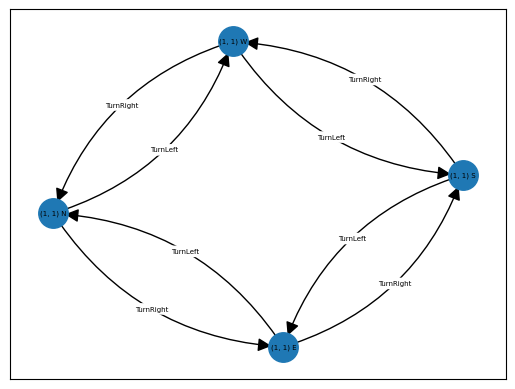

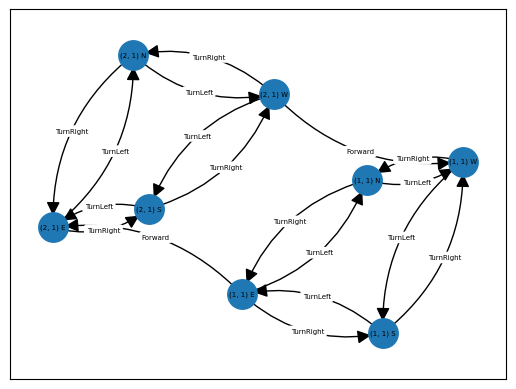

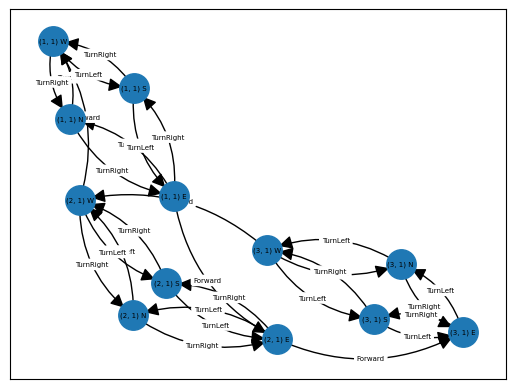

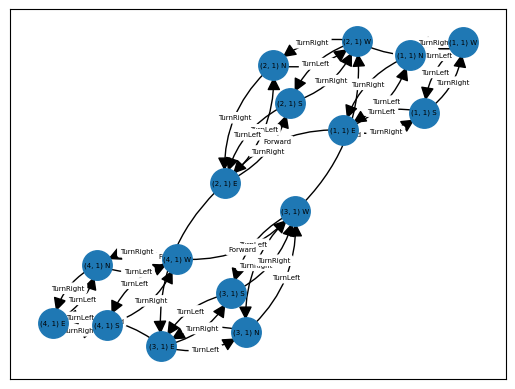

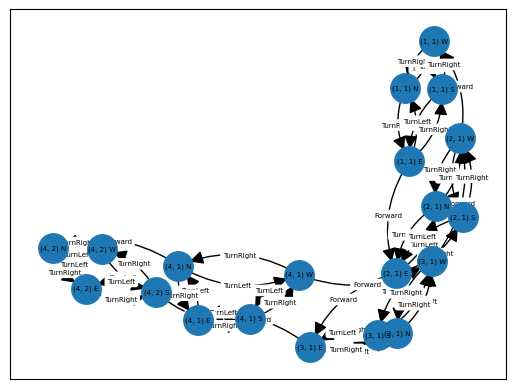

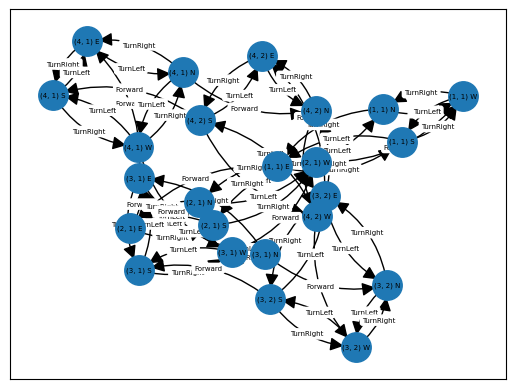

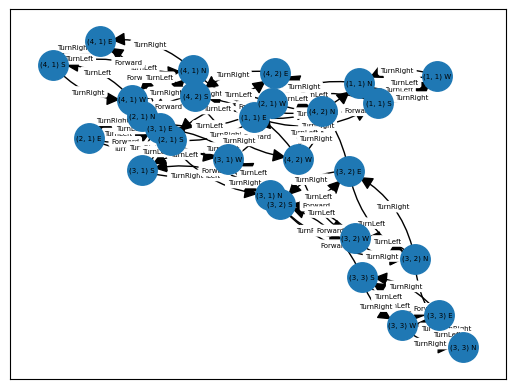

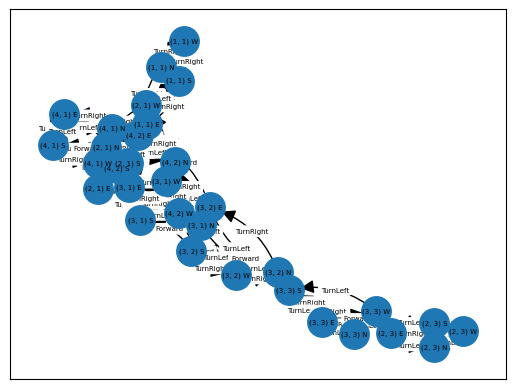

In [24]:
# Test 1
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)

Environment Initialization:
|    |    |    |    |
|    |    |    |  W |
|    |    |    |    |
|A   |   G|    |    |
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.LEFT

Agent Orientation: N
|    |    |    |    |
|    |    |    |  W |
|    |    |    |    |
|A   |   G|    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulative reward: -1
----------------------------------------------------------------------------------------------------

Action: Action.SHOOT

Agent Orientation: W
|    |    |    |    |
|    |    |    |  W |
|    |    |    |    |
|A   |   G|    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulati

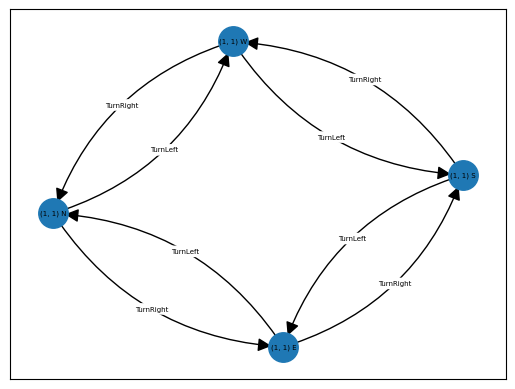

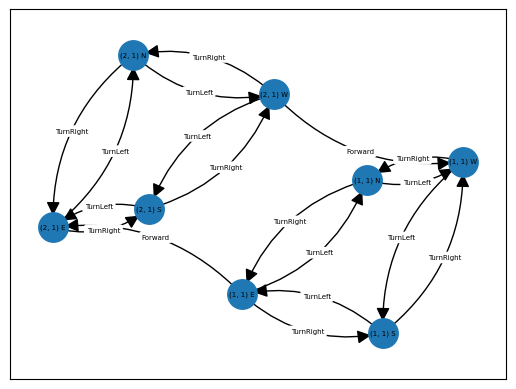

In [13]:
# Test 2
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)

Environment Initialization:
|    |   G|    |    |
|    |    |    |    |
|    |    |    |  W |
|A   |    |    |    |
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.SHOOT

Agent Orientation: E
|    |   G|    |    |
|    |    |    |    |
|    |    |    |  W |
|A   |    |    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-10, Done=False
Cumulative reward: -10
----------------------------------------------------------------------------------------------------

Action: Action.FORWARD

Agent Orientation: E
|    |   G|    |    |
|    |    |    |    |
|    |    |    |  W |
|    |A   |    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cum

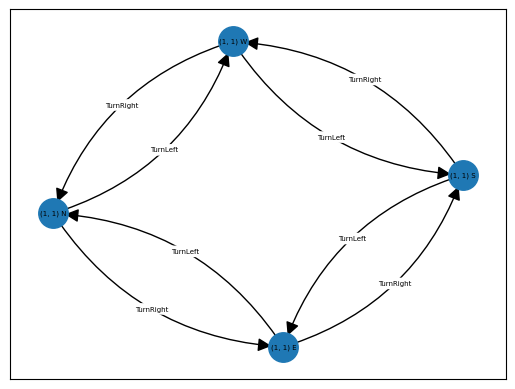

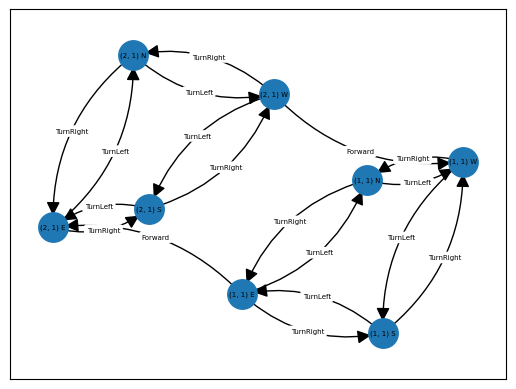

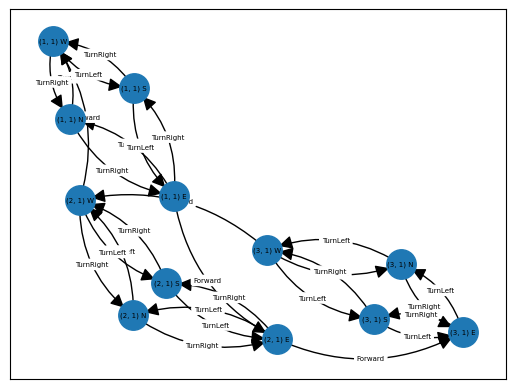

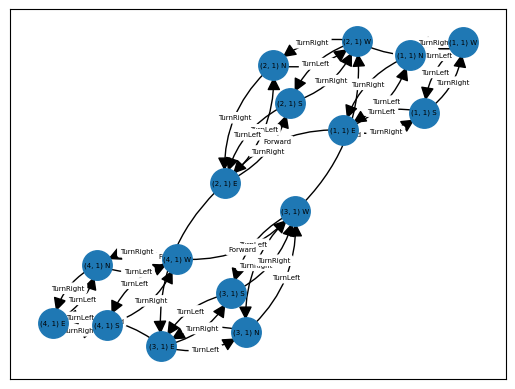

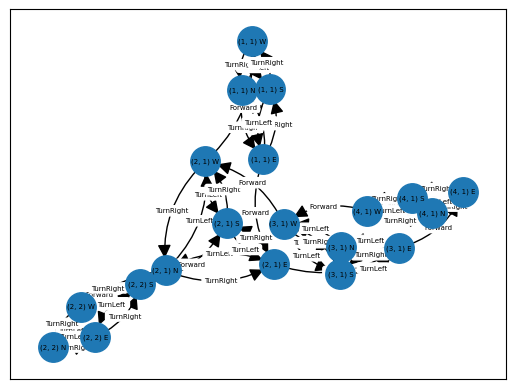

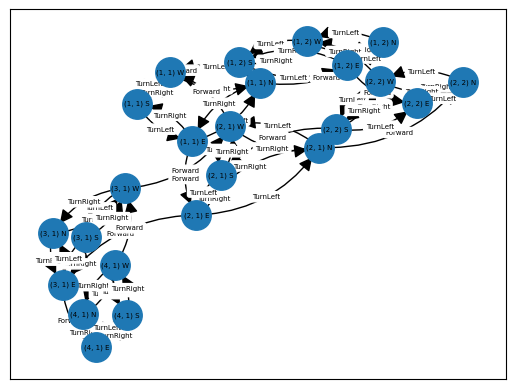

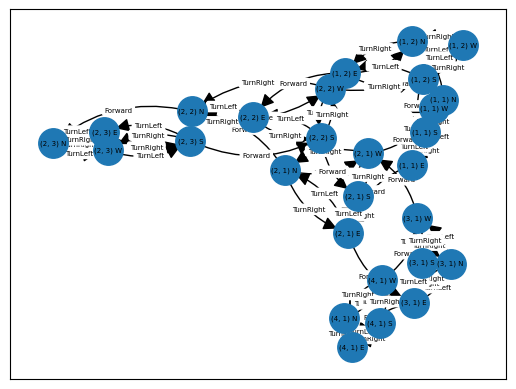

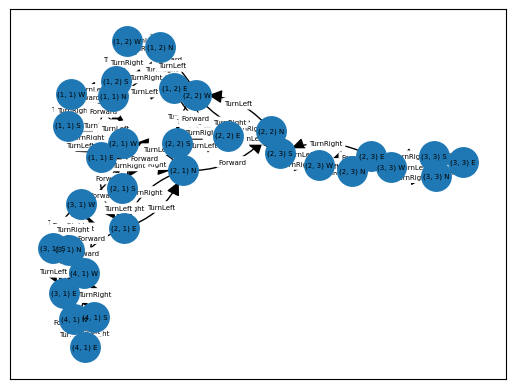

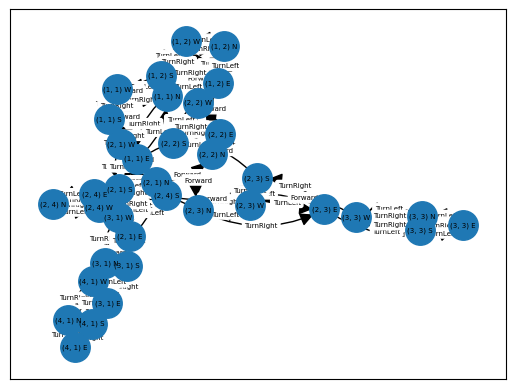

In [15]:
# Test 2
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)

Environment Initialization:
|    |    |    |    |
|  W |    |   G|    |
|    |    |    |    |
|A   |    |    |    |
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.FORWARD

Agent Orientation: E
|    |    |    |    |
|  W |    |   G|    |
|    |    |    |    |
|    |A   |    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulative reward: -1
----------------------------------------------------------------------------------------------------

Action: Action.FORWARD

Agent Orientation: E
|    |    |    |    |
|  W |    |   G|    |
|    |    |    |    |
|    |    |A   |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cum

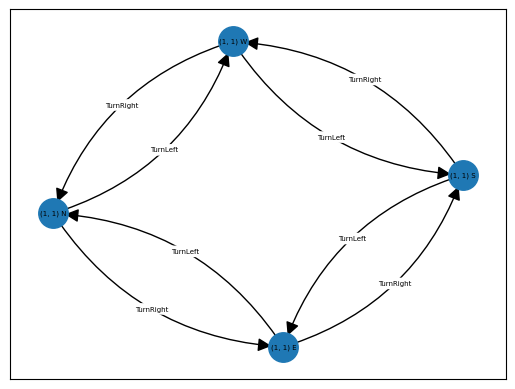

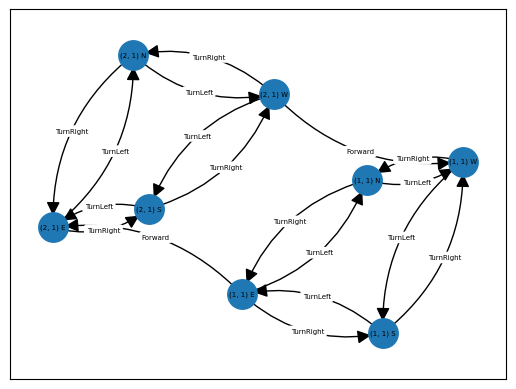

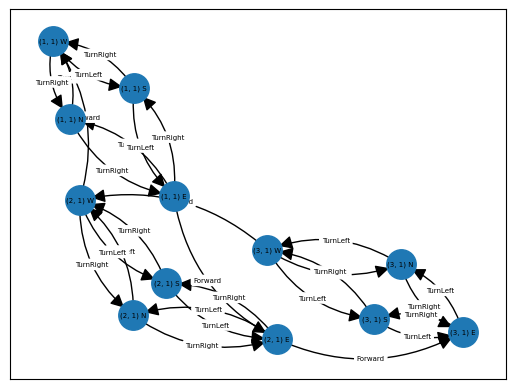

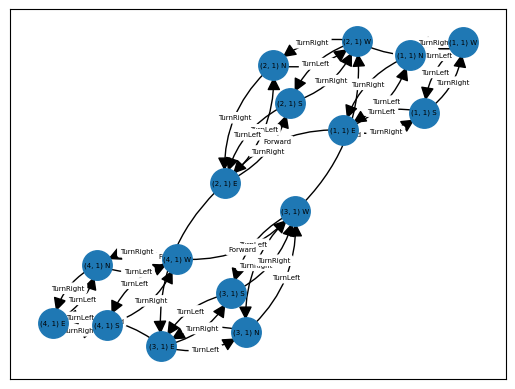

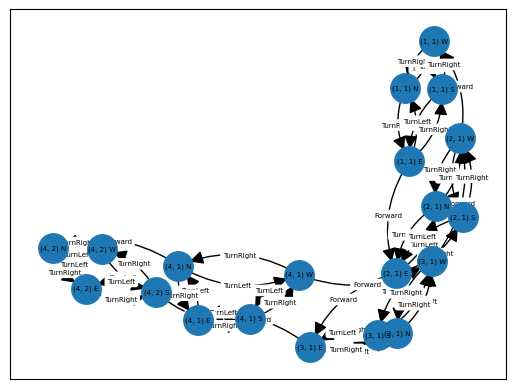

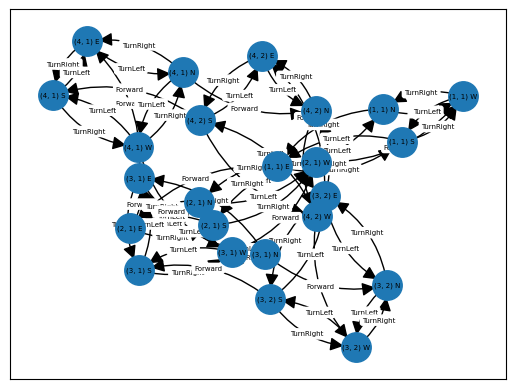

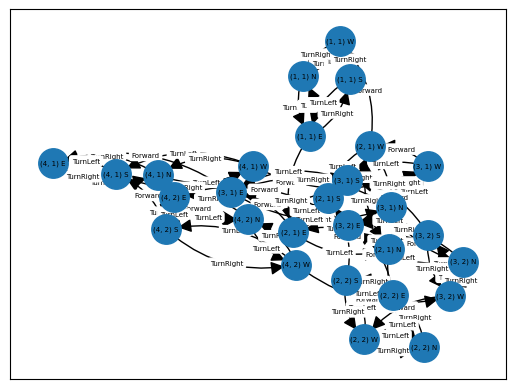

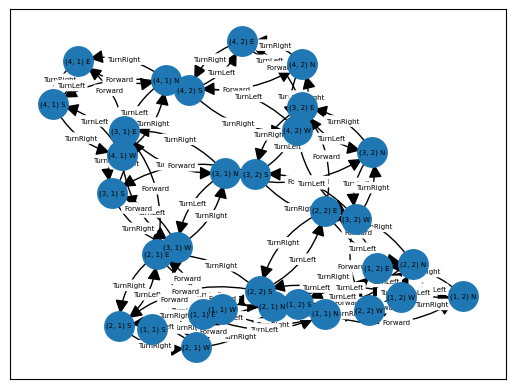

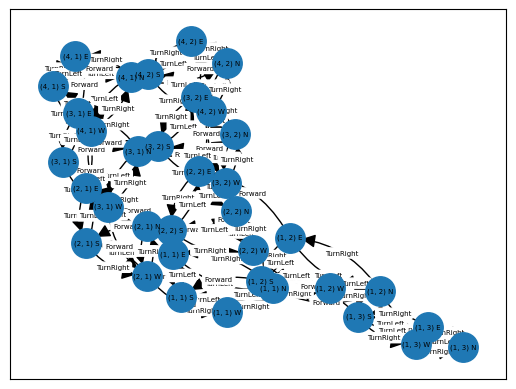

In [16]:
# Test 4
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)

Environment Initialization:
|    |    |    |  W |
|    |    |    |    |
|    |    |    |    |
|A   |    |   G|    |
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.RIGHT

Agent Orientation: S
|    |    |    |  W |
|    |    |    |    |
|    |    |    |    |
|A   |    |   G|    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulative reward: -1
----------------------------------------------------------------------------------------------------

Action: Action.FORWARD

Agent Orientation: S
|    |    |    |  W |
|    |    |    |    |
|    |    |    |    |
|A   |    |   G|    |
Percept: Percepts: Time Step=1, Bump=True, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumula

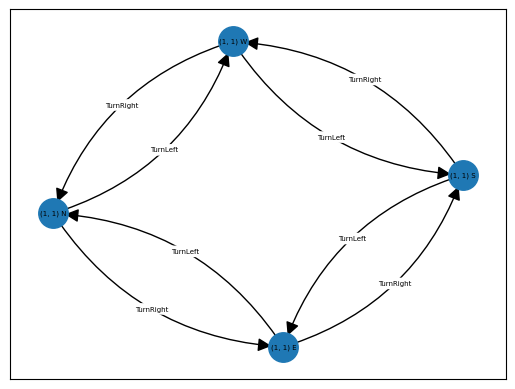

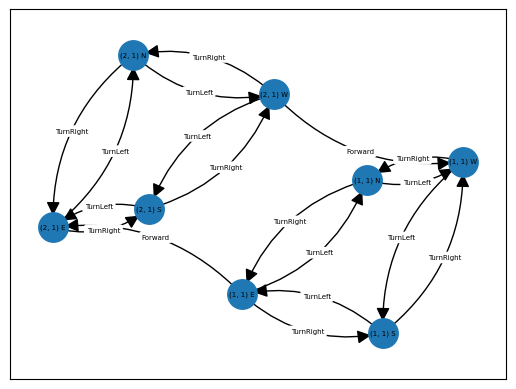

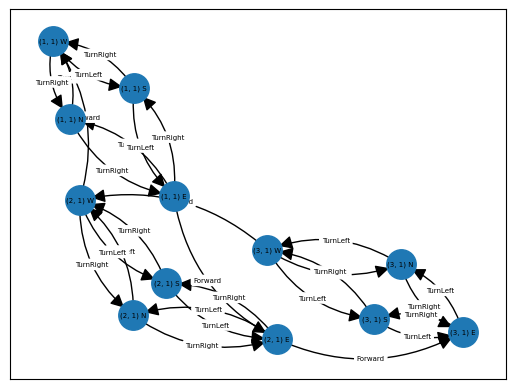

In [17]:
# Test 5
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)

Environment Initialization:
|    |  W |    |    |
|    |    |    |    |
|    |    |    |    |
|A   |    |    |   G|
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.LEFT

Agent Orientation: N
|    |  W |    |    |
|    |    |    |    |
|    |    |    |    |
|A   |    |    |   G|
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulative reward: -1
----------------------------------------------------------------------------------------------------

Action: Action.LEFT

Agent Orientation: W
|    |  W |    |    |
|    |    |    |    |
|    |    |    |    |
|A   |    |    |   G|
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulativ

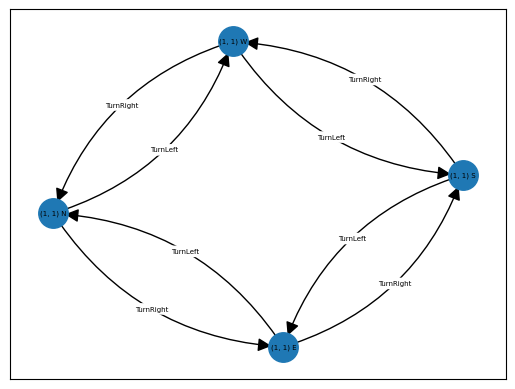

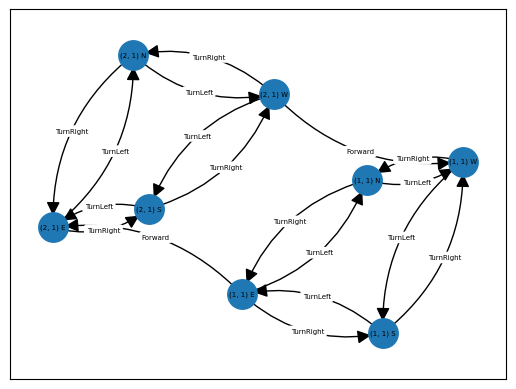

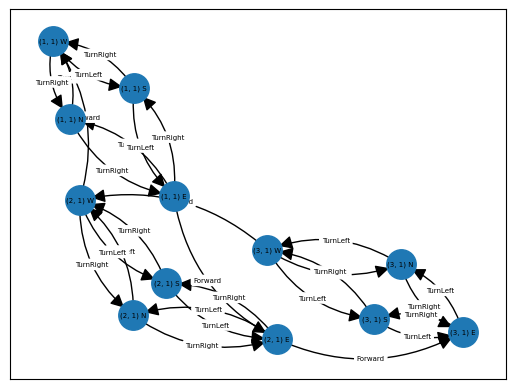

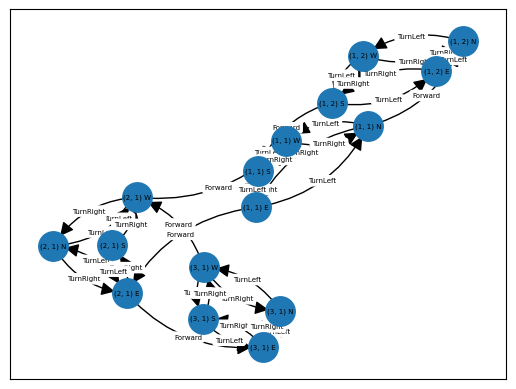

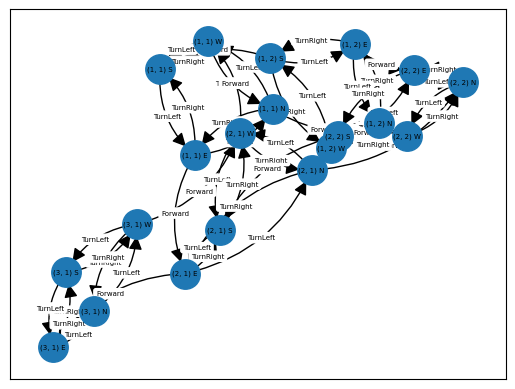

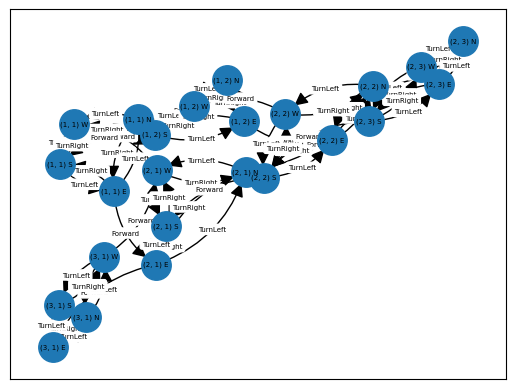

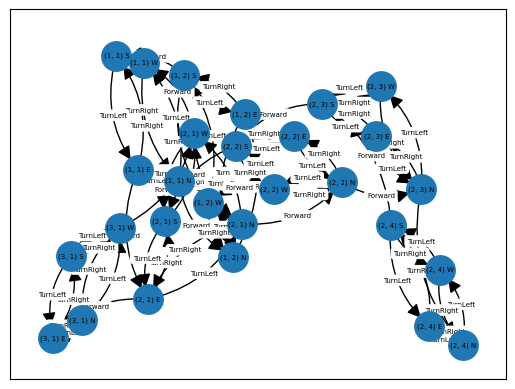

In [18]:
# Test 6
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)

Environment Initialization:
|    |    |    |   G|
|    |    |    |    |
|    |    |    |  W |
|A   |    |    |    |
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.LEFT

Agent Orientation: N
|    |    |    |   G|
|    |    |    |    |
|    |    |    |  W |
|A   |    |    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulative reward: -1
----------------------------------------------------------------------------------------------------

Action: Action.SHOOT

Agent Orientation: N
|    |    |    |   G|
|    |    |    |    |
|    |    |    |  W |
|A   |    |    |    |
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=-10, Done=False
Cumulat

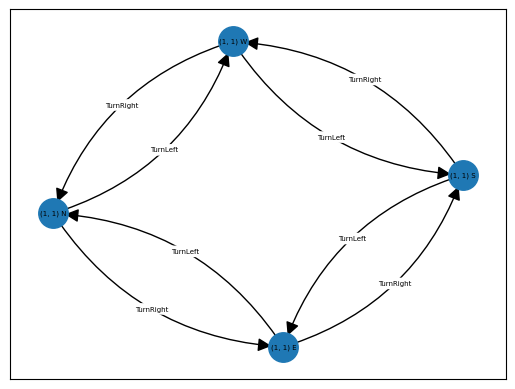

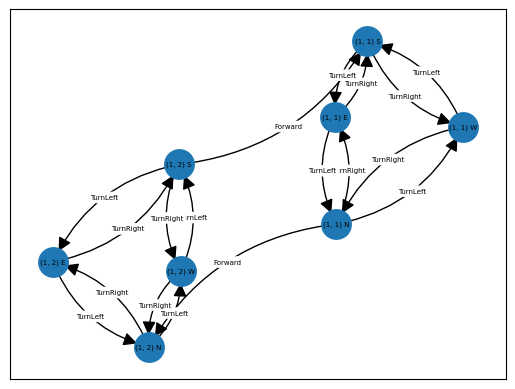

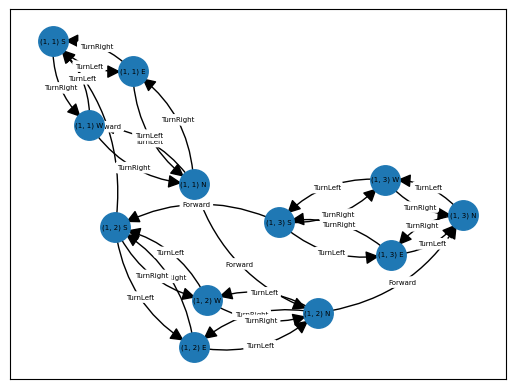

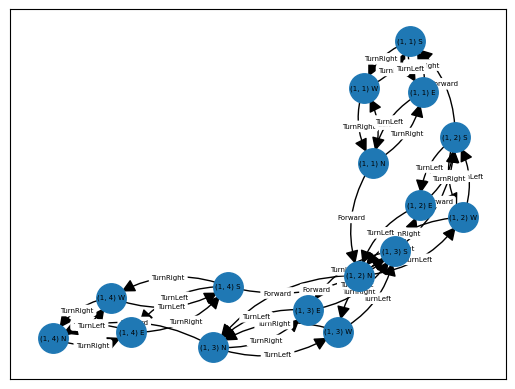

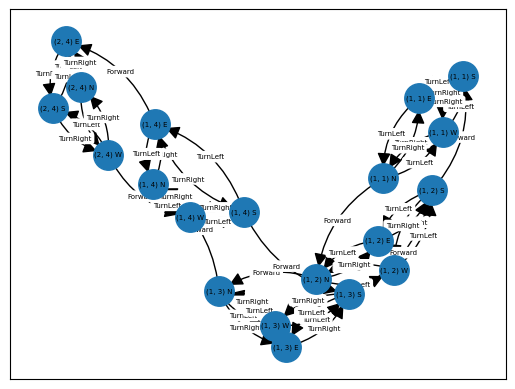

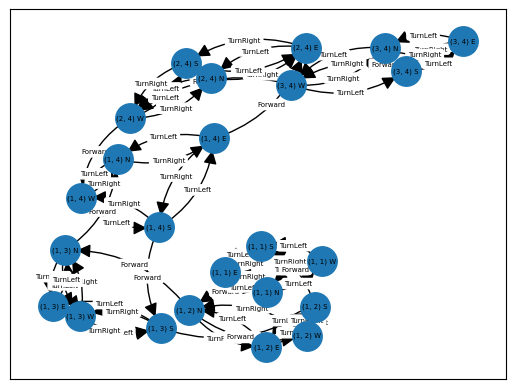

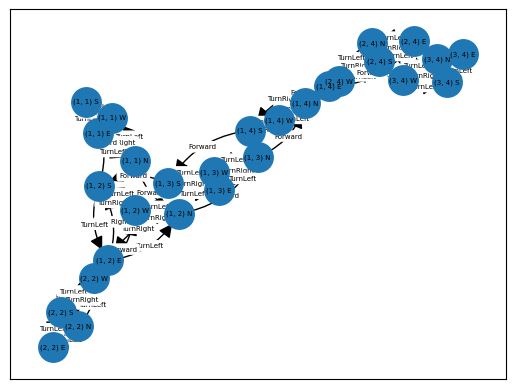

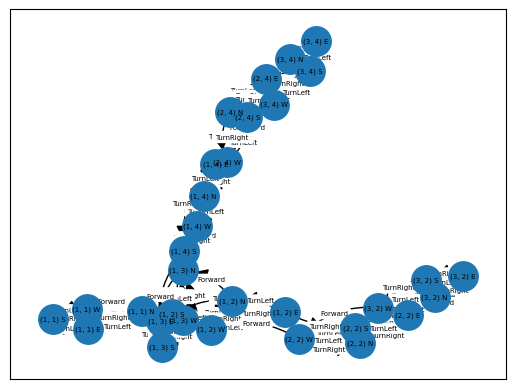

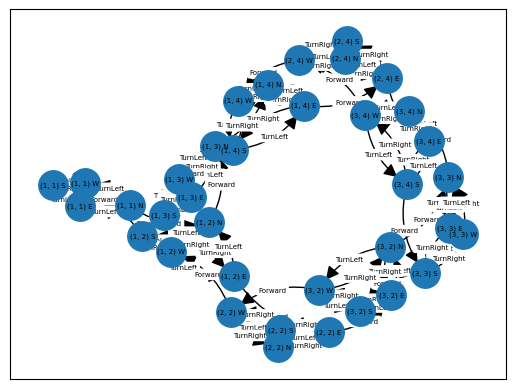

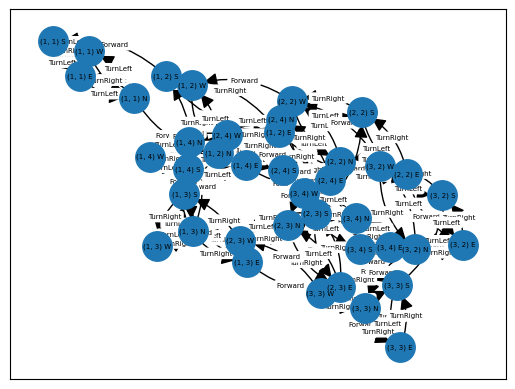

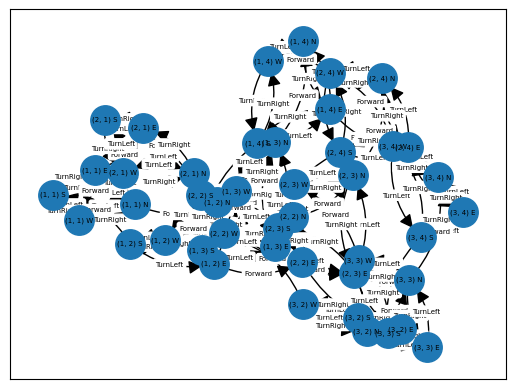

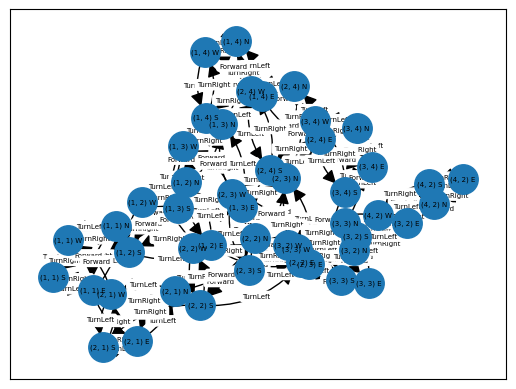

In [19]:
# Test 7
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)

Environment Initialization:
|    |    |    |    |
|    |    |    |    |
|    |    |    |    |
|A   |    |  W |   G|
Percept: Percepts: Time Step=0, Bump=False, Breeze=False, Stench=False, Scream=False, Glitter=False, Reward=0, Done=False
Cumulative reward: 0
----------------------------------------------------------------------------------------------------

Action: Action.FORWARD

Agent Orientation: E
|    |    |    |    |
|    |    |    |    |
|    |    |    |    |
|    |A   |  W |   G|
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=True, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulative reward: -1
----------------------------------------------------------------------------------------------------

Action: Action.LEFT

Agent Orientation: N
|    |    |    |    |
|    |    |    |    |
|    |    |    |    |
|    |A   |  W |   G|
Percept: Percepts: Time Step=1, Bump=False, Breeze=False, Stench=True, Scream=False, Glitter=False, Reward=-1, Done=False
Cumulati

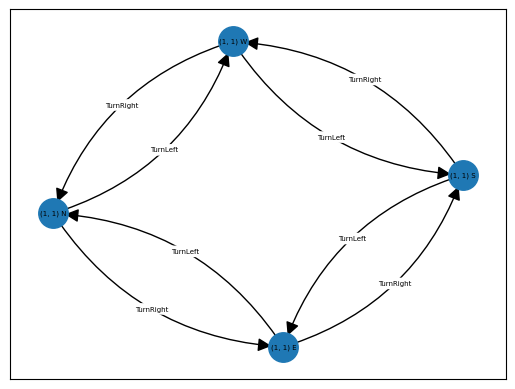

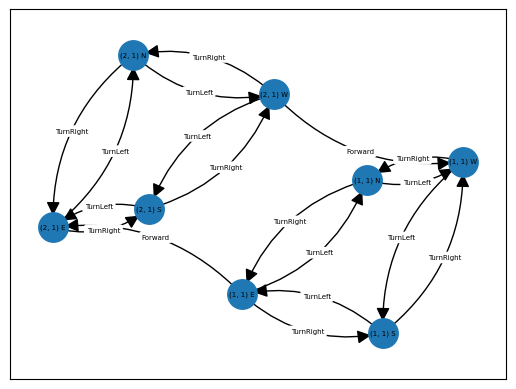

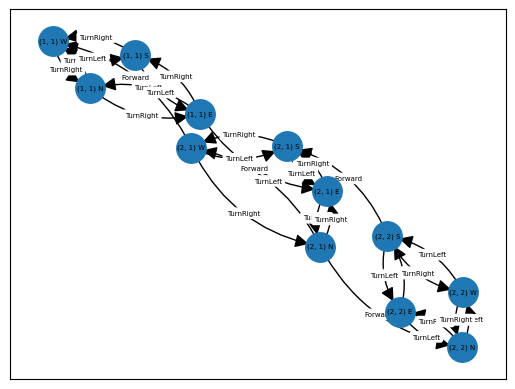

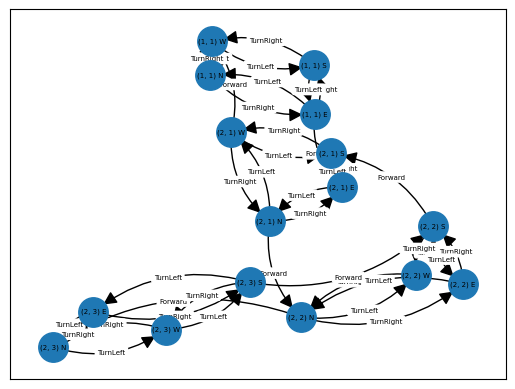

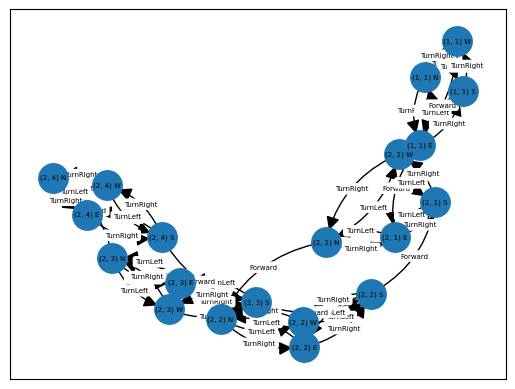

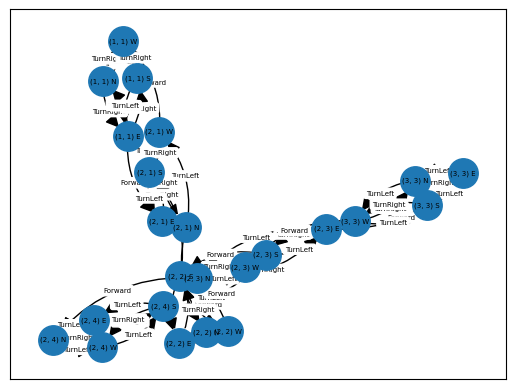

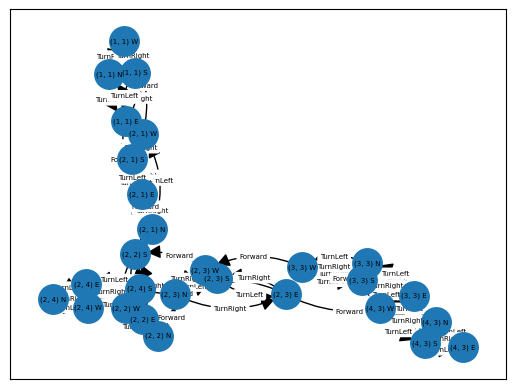

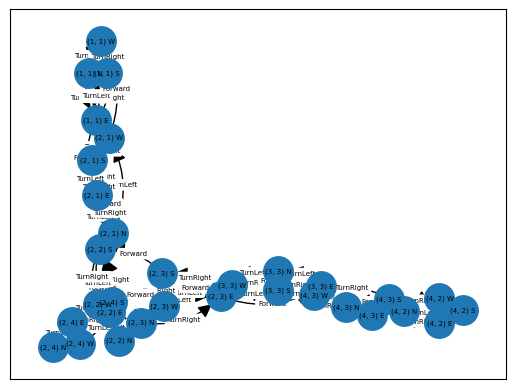

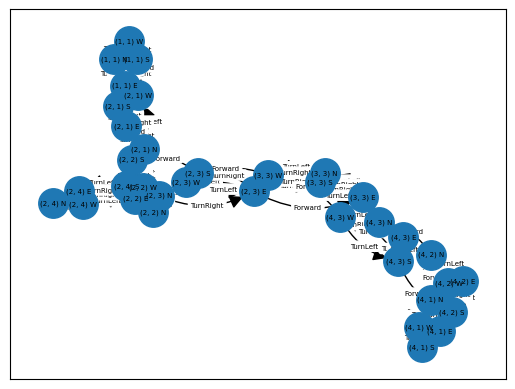

In [20]:
# Test 8
planning_agent_game = MovePlanningAgent()
planning_agent_game.run(WORLD_SIZE_x, WORLD_SIZE_y, True, 0)